In [2]:
%matplotlib inline
import lightkurve as lk
# from lightkurve_ext import download_lightcurvefiles, of_sector, of_sectors
import tic_plot as tplt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [3]:
tic, sector = 154964405, 26

sr = lk.search_targetpixelfile(f"TIC{tic}", mission="TESS", author='SPOC', sector=sector)
display(sr.table)

tpf_coll = sr.download_all(download_dir='data')

tplt.beep()

print(tpf_coll)
tpf = tpf_coll[-1] # defaulted to the latest one
print(tpf, " , sector", tpf.sector)
print("     time:", tpf.time.min() , "-", tpf.time.max())
print("cadenceno:", tpf.cadenceno.min() , "-", tpf.cadenceno.max())

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,exptime,distance,obsID,obs_collection_products,dataproduct_type_products,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project_products,prvversion,proposal_id_products,productFilename,size,parent_obsid,dataRights_products,calib_level_products,author,mission,#,year,sort_order
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,s,arcsec,,,,,,,,,,,,,,,,,,,,,,,
str10,int64,str4,str47,str9,float64,float64,float64,float64,float64,str7,str4,float64,float64,str1,str1,float64,str10,str14,str3,str1,str4,int64,str4,str47,str1,str73,str6,bool,float64,str7,str8,str8,float64,float64,str8,str4,str10,str18,str1,str73,str7,str28,str2,str1,str4,str19,str3,str55,int64,str8,str6,int64,str4,object,object,int32,int32
timeseries,3,TESS,tess2020160202036-s0026-0000000154964405-0188-s,154964405,213.746754590738,85.3135339001474,59009.76421442,59034.63210615,120.0,Optical,TESS,600.0,1000.0,--,--,59064.0,Photometer,"Ricker, George",N/A,--,TESS,26,SPOC,CIRCLE ICRS 213.74675459 85.31353390 0.00138889,--,mast:TESS/product/tess2020160202036-s0026-0000000154964405-0188-s_lc.fits,PUBLIC,False,nan,science,27670166,70923313,120,0.0,27670166,TESS,timeseries,Target pixel files,S,mast:TESS/product/tess2020160202036-s0026-0000000154964405-0188-s_tp.fits,SCIENCE,Minimum Recommended Products,TP,--,SPOC,spoc-5.0.3-20200718,N/A,tess2020160202036-s0026-0000000154964405-0188-s_tp.fits,43879680,27670166,PUBLIC,2,SPOC,TESS Sector 26,None,2020,1


TargetPixelFileCollection of 1 objects:
    0: TessTargetPixelFile(TICID: 154964405)
TessTargetPixelFile(TICID: 154964405)  , sector 26
     time: 2010.2657094771982 - 2035.132212557201
cadenceno: 563625 - 581529


In [ ]:
# tpf = tpf_coll[0]  # in case we want to use TPF that is not the latest

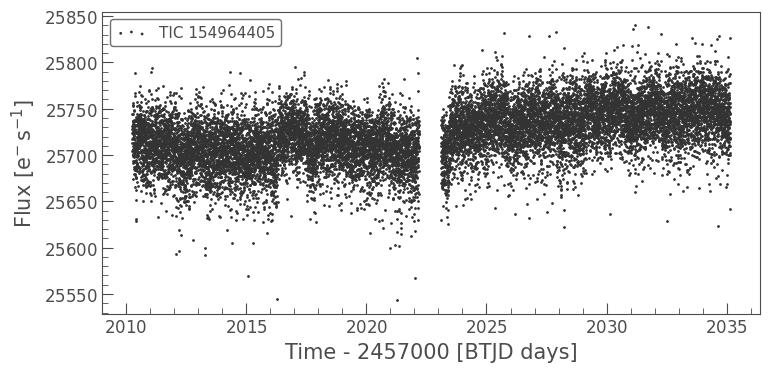

In [3]:
lc = tpf.to_lightcurve().remove_outliers(sigma=7)
ax = lc.scatter();
# ax.set_xlim(2260, 2261);
# ax.set_ylim(19300, 19800)

In [4]:
# ylim_func = lambda lc: (lc.flux.min(), lc.flux.max())
ylim_func = lambda lc: (np.nanmin(lc.flux), np.nanmax(lc.flux))
# ylim_func = lambda lc: (np.nanpercentile(lc.flux, 0.1), np.nanpercentile(lc.flux, 99.9))
# ylim_func = None
# ylim_func = lambda lc: (0.0, lc.flux.max())

transit_times = [2017.7] 
plot_start, plot_end = transit_times[0] - 2.0,  transit_times[0] + 2.0

# tpf_trunc = tpf
tpf_trunc = tpf[(tpf.time.value >= plot_start) & (tpf.time.value <= plot_end)]  # for Lightkurve 2 API
tpf_trunc.interact(ylim_func=ylim_func
#                    , aperture_mask=tpf.background_mask
                  )


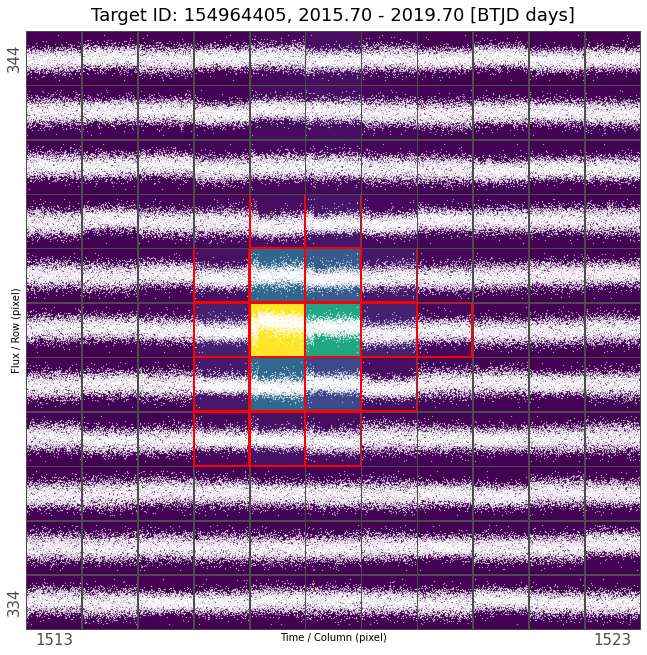

In [5]:
pixel_size_inches = 1
fig = plt.figure(figsize=(tpf.flux[0].shape[0] * pixel_size_inches, tpf.flux[0].shape[1] * pixel_size_inches))
ax = tpf_trunc.plot_pixels(ax=fig.gca(), aperture_mask='pipeline', show_flux=True, markersize=1.5);


In [6]:
tpf_mag = tpf_trunc.meta['TESSMAG']
print('Target magnitude: ', tpf_mag)
tpf_trunc.interact_sky(magnitude_limit = tpf_mag + 6);

Target magnitude:  9.39758015


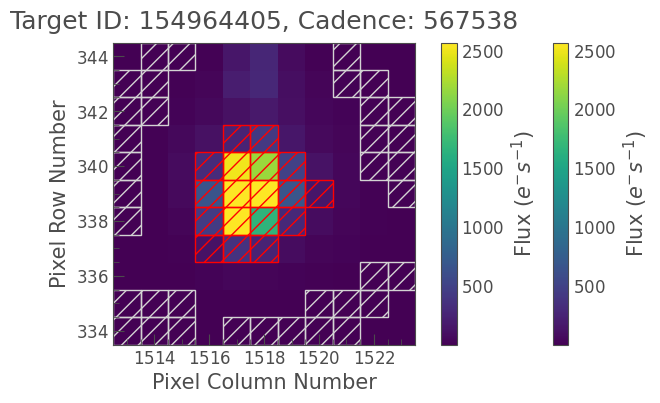

In [9]:
frame = 0
# tpf_trunc = tpf

ax = tpf_trunc.plot(aperture_mask='pipeline', mask_color='red')
ax = tpf_trunc.plot(ax=ax, aperture_mask=tpf.background_mask, mask_color='lightgray')


In [10]:
tpf_trunc.animate(aperture_mask='pipeline', mask_color='red')

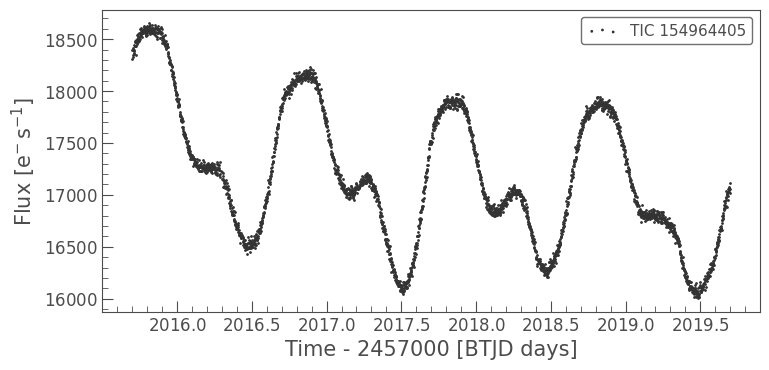

In [11]:
# tpf_trunc = tpf[(tpf.time >= 2075.0) & (tpf.time <= 2077.0)]
ax = tpf_trunc.get_bkg_lightcurve().scatter()
# ax.set_xlim(2075, 2077)

In [30]:
res = tpf_trunc._parse_aperture_mask('pipeline')
res


array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, Fal

In [ ]:
# mark time of interest to see the dip in target coinicdes with increase in background flux
t_epoch = 2014.101561
period = 9.07
duration_hr = 3.2 # divide transit duration to highlight only the deepest part
duration = duration_hr / 24

time_interest = t_epoch + period * 1
zoom_x = True
zoom_x_half_width = 0.5 # duration * 10

lc = tpf.to_lightcurve().normalize()
ax = lc.scatter()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.axvline(x=time_interest, ymin=0.0, ymax=0.3, color='red')
# plt.ylim(0.995, 1.0075)
if zoom_x:
    plt.xlim(time_interest - zoom_x_half_width, time_interest + zoom_x_half_width)

bkg_lc = tpf.get_bkg_lightcurve().normalize()
ax = bkg_lc.scatter()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.ylim(0.8, 1.2)
plt.axvline(x=time_interest, ymin=0.0, ymax=0.3, color='red')
if zoom_x:
    plt.xlim(time_interest - zoom_x_half_width, time_interest + zoom_x_half_width)


In [ ]:
# try to create background lightcurve from the pipeline-provided masks
# it's similar but isn't quite the same
n_target_pixels = tpf.pipeline_mask.sum()
n_background_pixels = tpf.background_mask.sum()

lc_background_per_pixel = tpf.to_lightcurve(aperture_mask=tpf.background_mask) / n_background_pixels
lc_background_custom = lc_background_per_pixel * n_target_pixels

lc_background_custom.normalize().scatter()

# compare the constructed background lightcurve with the one provided by TPF directly
bkg_lc.scatter()